In [22]:
import pandas as pd
import numpy as np

from skopt.space import Real, Integer
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

from scipy.stats import qmc  

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [23]:
df = pd.read_csv('Drone_Data_80.csv')

df

,Length (mm),Depth (mm),Length_to_Depth_Ratio,Max Principal Strain (Compensated),Equivalent Strain (Compensated)
0,403.1,101.0,3.991089,1.640000e-08,2.190000e-08
1,399.9,100.9,3.963330,1.480000e-08,1.950000e-08
2,403.0,99.5,4.050251,1.210000e-08,1.710000e-08
3,397.8,99.7,3.989970,1.090000e-08,1.460000e-08
4,398.0,99.1,4.016145,9.710000e-09,1.220000e-08
...,...,...,...,...,...
74,431.0,108.7,3.965041,3.540000e-10,1.040000e-09
75,385.0,119.2,3.229866,4.120000e-09,7.010000e-09
76,410.5,116.3,3.529665,6.160000e-09,6.130000e-09
77,385.0,97.8,3.936605,4.360000e-10,7.370000e-09


In [24]:
# Scale the 'Maximum Principal Elastic Strain' column by 10^10
df['Max Principal Strain (Compensated)'] = df['Max Principal Strain (Compensated)'] * 1e10

# Optionally, check the updated values
print(df.head())

   Length (mm)  Depth (mm)  Length_to_Depth_Ratio  \
0        403.1       101.0               3.991089   
1        399.9       100.9               3.963330   
2        403.0        99.5               4.050251   
3        397.8        99.7               3.989970   
4        398.0        99.1               4.016145   

   Max Principal Strain (Compensated)  Equivalent Strain (Compensated)  
0                               164.0                     2.190000e-08  
1                               148.0                     1.950000e-08  
2                               121.0                     1.710000e-08  
3                               109.0                     1.460000e-08  
4                                97.1                     1.220000e-08  


In [25]:
# Define the hyperparameter space
hyp_space  = [
    Integer(3, 10, name='num_layers'), # Num of layers in the network (depth)
    Integer(50, 200, name='num_units'), # Num of neurons in each hidden layer (width)
    Real(0.00001, 0.1, prior='log-uniform', name='learning_rate'), # Steps size at each iteration 
    Real(0.0, 0.5, name='dropout_rate'), # Probability of droping out a neuron
    Integer(20, 150, name='batch_size'), # Num of samples per batch
    Integer(50, 200, name='epochs') # Num of epochs (iterations over the entire dataset) during training
]

# Defining the Neural Network Model
def NN_model(num_layers, num_units, learning_rate, dropout_rate):
    inputs = Input(shape=(2,))
    x = Dense(num_units, activation='relu', kernel_regularizer='l2')(inputs)
    for _ in range(num_layers - 1):
        x = Dense(num_units, activation='relu', kernel_regularizer='l2')(x)
        x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Function for MC Dropout predictions
def mc_dropout_predictions(model, X, num_samples=50):
    predictions = np.zeros((num_samples, X.shape[0]))
    for i in range(num_samples):
        predictions[i, :] = model(X, training=True).numpy().flatten()
    prediction_mean = predictions.mean(axis=0)
    prediction_std = predictions.std(axis=0)
    return prediction_mean, prediction_std

In [26]:
# Define the objective function to minimize
@use_named_args(hyp_space)
def objective(**params):
    num_layers = params['num_layers']
    num_units = params['num_units']
    learning_rate = params['learning_rate']
    dropout_rate = params['dropout_rate']
    batch_size = params['batch_size']
    epochs = params['epochs']

    model = NN_model(num_layers, num_units, learning_rate, dropout_rate)

    # Define K-fold cross-validation
    kfold = KFold(n_splits=3, shuffle=True, random_state=0)
    scores = []

    # Perform cross-validation
    for train_idx, val_idx in kfold.split(df[['Length (mm)', 'Depth (mm)']]):
        X_train, X_val = df[['Length (mm)', 'Depth (mm)']].iloc[train_idx], df[['Length (mm)', 'Depth (mm)']].iloc[val_idx]
        y_train, y_val = df[['Max Principal Strain (Compensated)']].iloc[train_idx], df[['Max Principal Strain (Compensated)']].iloc[val_idx]

        # Standardize the features
        scaler_x = StandardScaler().fit(X_train)
        X_train_scaled = scaler_x.transform(X_train)
        X_val_scaled = scaler_x.transform(X_val)

        # Train the model
        # early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(X_val_scaled, y_val))

        # Evaluate the model
        score = model.evaluate(X_val_scaled, y_val, verbose=0)
        scores.append(score)
    
    return np.mean(scores)

# Perform Bayesian optimization
result = gp_minimize(objective, hyp_space, n_calls=30, random_state=0, acq_func='EI')

# Output best hyperparameters from BayesOpt
print("Best hyperparameters:")
print("num_layers:", result.x[0])
print("num_units:", result.x[1])
print("learning_rate:", result.x[2])
print("dropout_rate:", result.x[3])
print("batch_size:", result.x[4])
print("epochs:", result.x[5])

# Train the model with the best hyperparameters
best_model = NN_model(
    num_layers=result.x[0],
    num_units=result.x[1],
    learning_rate=result.x[2],
    dropout_rate=result.x[3],
)

Best hyperparameters:
num_layers: 4
num_units: 185
learning_rate: 0.004383727497967208
dropout_rate: 0.40465200367066245
batch_size: 76
epochs: 162


In [27]:
from sklearn.model_selection import train_test_split

train_X = df[['Length (mm)', 'Depth (mm)']].to_numpy()
train_y = df['Max Principal Strain (Compensated)'].to_numpy()

# Standardize the initial dataset
scaler_x = StandardScaler().fit(train_X)
X_scaled = scaler_x.transform(train_X)

Epoch 1/162
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 24471.6094
Epoch 2/162
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24310.6387 
Epoch 3/162
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 23809.7422 
Epoch 4/162
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 23082.3672 
Epoch 5/162
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21990.3535 
Epoch 6/162
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21863.7930 
Epoch 7/162
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 20983.9766 
Epoch 8/162
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21872.1836 
Epoch 9/162
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 20942.4434 
Epoch 10/162
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21426.8594 
Epoch 11/162
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21308.8184 
Epoch 12/162
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 20810.9277 
Epoch 13/162
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 20973.1387 
Epoch 14/162
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19808.5410 
Epoch 15/162
2/2 ━━━━━━━━━━━━━

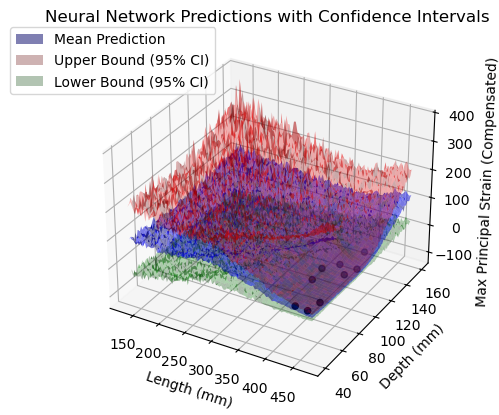

In [28]:
# Train the best model on training set
best_model.fit(X_scaled, train_y, epochs=result.x[5], batch_size=result.x[4], verbose=1)

# Produce Meshgrid of input space
x1_range = np.linspace(130, 470, 100)
x2_range  = np.linspace(40, 160, 100)

x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
x_grid = np.c_[x1_grid.ravel(), x2_grid.ravel()]

x_grid = scaler_x.transform(x_grid)

# Perform MC Dropout predictions for entire meshgrid
pred_mean, pred_std = mc_dropout_predictions(best_model, x_grid)

# Define range for inputs
bounds = np.array([[130, 470], [40, 160]])

# Identify top 10 points with highest uncertainty
num_new_points = 10

sampler = qmc.LatinHypercube(d=2)  # LHS in a 1D space
lhs_sample = sampler.random(n=1000)
lhs_points = qmc.scale(lhs_sample, bounds[:, 0], bounds[:, 1])

lhs_points_scaled = scaler_x.transform(lhs_points)

lhs_mean, lhs_std = mc_dropout_predictions(best_model, lhs_points_scaled)
percentile_threshold = 10 
threshold_value = np.percentile(lhs_mean, percentile_threshold)

# Filter points above the threshold
points_above_threshold = lhs_points[lhs_mean <= threshold_value]

num_new_points = 10
if len(points_above_threshold) > num_new_points:
    selected_indices = np.random.choice(len(points_above_threshold), num_new_points, replace=False)
    selected_points = points_above_threshold[selected_indices]
else:
    selected_points = points_above_threshold

new_points_df = pd.DataFrame(selected_points, columns=['x','y'])

# Ploting mean predictions and confidence intervals
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Reshaping predictions back to grid shape
pred_mean_grid = pred_mean.reshape(x1_grid.shape)
pred_upper_grid = (pred_mean + (1.96 * pred_std)).reshape(x1_grid.shape)
pred_lower_grid = (pred_mean - (1.96 * pred_std)).reshape(x1_grid.shape)

mean_surface = ax.plot_surface(x1_grid, x2_grid, pred_mean_grid, color='blue', alpha=0.5, label='Mean Prediction')
upper_surface = ax.plot_surface(x1_grid, x2_grid, pred_upper_grid, color='red', alpha=0.3, label='Upper Bound (95% CI)')
lower_surface = ax.plot_surface(x1_grid, x2_grid, pred_lower_grid, color='green', alpha=0.3, label='Lower Bound (95% CI)')

# Getting mean of new points for visualization
new_x = new_points_df[['x', 'y']].to_numpy()
new_x = scaler_x.transform(new_x)
new_mean, new_std = mc_dropout_predictions(best_model, new_x)


ax.scatter(selected_points[:, 0], selected_points[:, 1], new_mean, color='black', marker='o', label='Next Sampling Points')

# Plot Labels
ax.set_title('Neural Network Predictions with Confidence Intervals')
ax.set_xlabel('Length (mm)')
ax.set_ylabel('Depth (mm)')
ax.set_zlabel('Max Principal Strain (Compensated)')

# Legend
legend_elements = [mean_surface, upper_surface, lower_surface]
fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Show the plot
plt.show()

In [29]:
new_points_df

,x,y
0,433.004743,96.293709
1,415.989799,85.831214
2,460.592687,98.808353
3,417.260339,73.690044
4,364.212549,105.491887
5,458.279619,56.463361
6,450.936117,89.825454
7,452.295675,113.423072
8,434.425616,43.387889
9,454.290697,44.891146


In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = best_model.predict(X_scaled)

# # Calculate regression metrics
mse = mean_squared_error(train_y, y_pred)
mae = mean_absolute_error(train_y, y_pred)
r2 = r2_score(train_y, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000261CB227EC0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Mean Squared Error (MSE): 20110.06922670537
Mean Absolute Error (MAE): 45.44933046703097
R² Score: 0.0019737846013639926
